# Collecting user input

One frequently wants to collect interactively collect input from the user, for example to draw a curve or region of interest on a graph or to drill down into complex data sets.

Matplotlib has support for collecting mouse events (motion, clicks, and scrolling) and keyboard events (key up/down + command keys) from the UI.  This machinery is how the pan / zoom / hotkeys configured by default in Matplotlib work, this tutorial will show you how to use this machinery for your own purposes.

To start with, we will need to be using either the nbagg or ipypmpl and ensure that any print statements in our callbacks will make it back to the notebook.

Output()

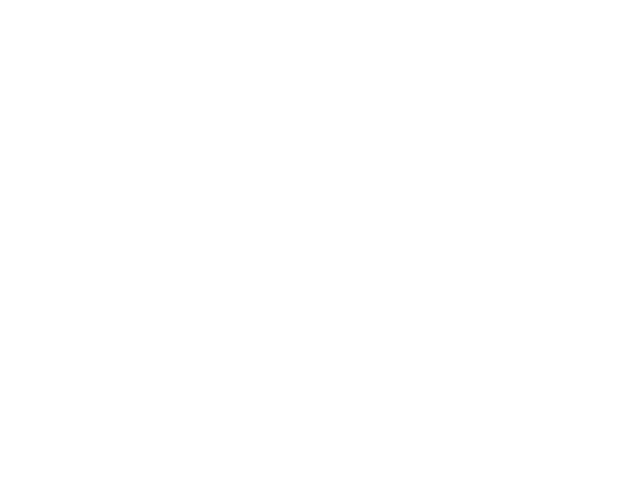

In [5]:
# pick widget or notebook.  Widget works in Jupyter Lab, but requires ipympl to be installed
#%matplotlib notebook
# nbagg ships as part of Matplotlib, but does not work in Jupyter Lab

%matplotlib widget
# make sure prints come to the notebook
%run helpers/ensure_print.py

To start lets interactively build a curve based on the points the users clicks on. To get notified when the user clicks we register a callback with the canvas.  This is the same idea as e.g. `on_click` in jquery or signal/slots in Qt, we provide a function that will be called on our behalf when the user takes some action.  To register a callabck we use the `canvas.mpl_connect` method which has the signature:

```python
def mpl_connect(self, s: str, func : Callable[Event]):
    ...

```

`s` can be one of the 14 strings defining when we want our function called and the exact sub-class of `Event` that is passed in depends on the value of `s`.




## Button Press Callbacks


[`MouseEvent`](https://matplotlib.org/3.1.1/api/backend_bases_api.html#matplotlib.backend_bases.MouseEvent) provides use acceses to what axes we are in, the mouse button that was clicked, any modified keys the user was holding down, and the location of the mouse.
The attributes on the `event` that we are going to primarily conecerned with are:

```python
def callback(event : MouseEvent) -> None:
    button = event.button   # the button clicked as an Enum
    x = event.xdata         # the x location of the click in *data space*
    y = event.ydata         # the y locatino of the click in *data space*
    key = event.key         # any keyboard key that is held down while clicking
```

The values of  [MouseButton](https://matplotlib.org/3.1.1/api/backend_bases_api.html#matplotlib.backend_bases.MouseButton) we are interested in are

```python
from matplotlib.backend_bases import MouseButton
MouseButton.LEFT == 1
MouseButton.RIGHT == 3
```

In the browser both the middle and right button report as `MouseButton.RIGHT` because the right mouse button in the browser always opens a context menu. 



## Capture the Clicks

As we are collecting state lets define a helper-class that is going to own the interaction and wrap around the `Line2D` artist that is drawing our curve.  To start with we will just print out _where_ the user clicked and with which button.

In [6]:
import matplotlib.pyplot as plt
from itertools import cycle
# available on mpl >= 3.1
# from matplotlib.backend_bases import MouseButton

class LineMaker:
    def __init__(self, ln):
        # Stash the Line2D object, we will use this later
        self.ln = ln
        # register our method to be called when the mouse button is pressed down
        self.button_cid = ln.figure.canvas.mpl_connect('button_press_event',
                                                       self.on_button)

    def on_button(self, event):
        # print out what button and where the user clicked
        print(f'button: {event.button!r} @ ({event.xdata}, {event.ydata}) + key: {event.key}')

Output()

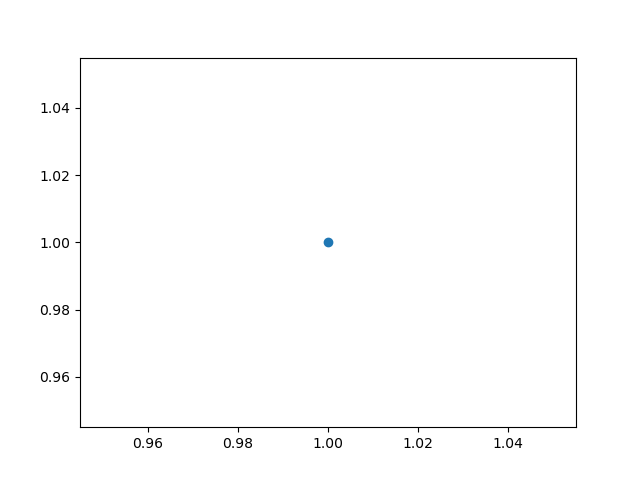

In [7]:
fig, ax = plt.subplots()
ln, = ax.plot([1], [1], '-o')
line_maker = LineMaker(ln)

### Exercise

Only print when the left buton is pressed.

Now we need to record where the user clicked and update the `Line2D` artist.  It is critical that we remember to call `draw_idle` at the end or the UI will not update to reflect our changes.

In [8]:
class LineMaker:
    def __init__(self, ln):
        # stash the Line2D artist
        self.ln = ln
        ln.axes.annotate('Left-click to add points', (.5, .9), 
                      ha='center', xycoords='axes fraction')
        # register our method to be called per-click
        self.button_cid = ln.figure.canvas.mpl_connect('button_press_event',
                                                       self.on_button)

    def on_button(self, event):
        print(f'button: {event.button!r} @ ({event.xdata}, {event.ydata}) + key: {event.key}')
 
        # only consider events from the lines Axes or if not the left mouse button bail! 
        if event.inaxes is not self.ln.axes or event.button != 1:
            return
   
        # append the new point to the current Line2D data
        xdata = list(self.ln.get_xdata()) + [event.xdata]
        ydata = list(self.ln.get_ydata()) + [event.ydata]

        # and update the data on the Line2D artist
        self.ln.set_data(xdata, ydata)

        # ask the UI to re-draw the next time it can
        self.ln.figure.canvas.draw_idle()
        
    @property
    def curve(self):
        # get the current (x, y) for the line
        return {'x': self.ln.get_xdata(), 'y': self.ln.get_ydata()}



Output()

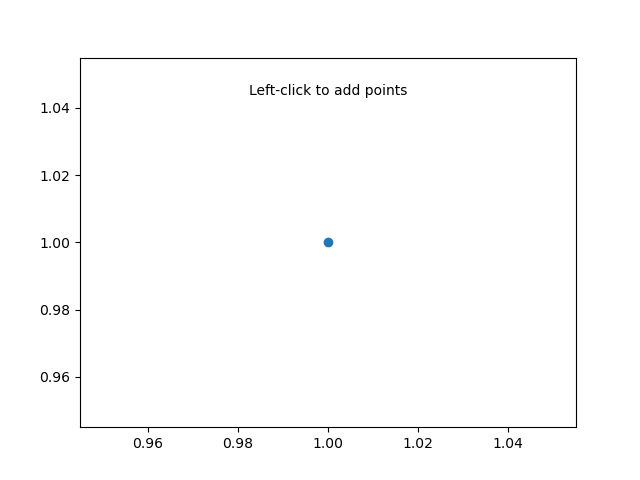

In [9]:
fig, ax = plt.subplots()
ln, = ax.plot([1], [1], '-o')
line_maker = LineMaker(ln)

We can use the the `curve` attribute on `line_maker` to get the current (x, y) data and when we are happy with it feed it into the next step of our analysis.

In [ ]:
print(line_maker.curve)

### Exercise

Being able to add points to our line is great!  However, what if we make a mistake and want to remove a point?  One way for the user to express they would like to remove the point is to hold down 'shift' while clicking.

In this exercise, implement removing the nearest point from where the user clicked when they shift-click.

In [10]:
class LineMakerRemover(LineMaker):

    def on_button(self, event):
        # print out what button and where the user clicked
        print(f'button: {event.button!r} @ ({event.xdata}, {event.ydata}) + key: {event.key}')
 
        # only consider events from the lines Axes or if not the left mouse button bail!
        if event.inaxes is not self.ln.axes or event.button != MouseButton.LEFT:
            return
        
        xdata = list(self.ln.get_xdata())
        ydata = list(self.ln.get_ydata())

        if event.key == 'shift':
            print('in shift')
            # TODO compute the closest (x, y) point and remove it from 
            # xdata, ydata
        else:
            # append the new point to the current Line2D data
            xdata += [event.xdata]
            ydata += [event.ydata]

        # and update the data on the Line2D artist
        self.ln.set_data(xdata, ydata)

        # ask the UI to re-draw the next time it can
        self.ln.figure.canvas.draw_idle()




Output()

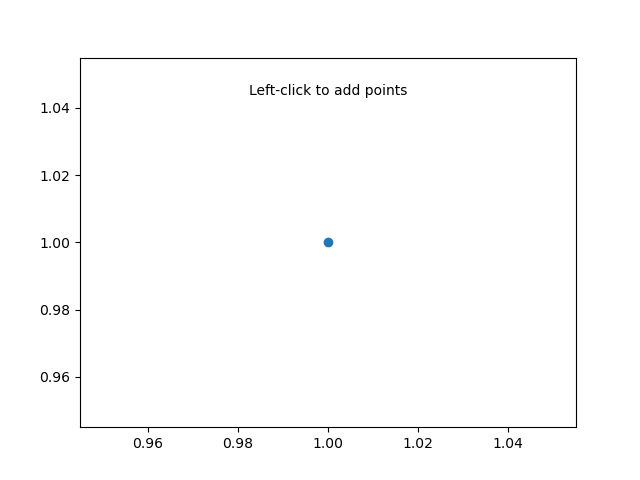

In [11]:
fig = plt.figure()
ax = fig.subplots()
ln, = ax.plot([1], [1], '-o')
line_maker = LineMaker(ln)